# Linear Frequency-Dependent PTO 

In [1]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_freqdep_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

### WEC

In [2]:
## WEC object
# mesh
wb = wot.geom.WaveBot() 
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Reading BEM data from results_linear_freqdep_pto/bem.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


### PTO

In [3]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0 
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        -1/(1j*wec.omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape) 
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])


# # PTO impedance - fixed
# gear_ratio = 12.4666
# torque_constant = 6.1745
# electrical_constant = 4.116
# winding_inductance = 0.5

# # full frequency-dependent impedance but same at each frequency
# pto_impedance_11 = (0.0+0j)*np.ones(wec.omega.shape)
# pto_impedance_12 = (torque_constant*gear_ratio+0j)*np.ones(wec.omega.shape)
# pto_impedance_21 = (electrical_constant*gear_ratio+0j)*np.ones(wec.omega.shape)
# pto_impedance_22 = (winding_inductance+0j)*np.ones(wec.omega.shape)
# pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
#                           [pto_impedance_21, pto_impedance_22]])

# # single 2x2 impedance matrix (no frequency dependence)
# pto_impedance_11 = 0.0
# pto_impedance_12 = torque_constant*gear_ratio
# pto_impedance_21 = electrical_constant*gear_ratio
# pto_impedance_22 = winding_inductance
# pto_impedance = np.array(
#   [[0.0,                            torque_constant*gear_ratio],
#    [electrical_constant*gear_ratio, winding_inductance]])


# create PTO
# pto = wot.pto.PseudoSpectralLinearPTO(nfreq, kinematics, pto_impedance)
pto = wot.pto.PLinearPTO(nfreq, kinematics, pto_impedance)

# add PTO force to WEC
wec.f_add = pto.force_on_wec

INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.


### Waves

In [4]:
# waves
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

### Objective Function

In [5]:
# objective function
obj_fun = pto.electric_average_power
nstate_opt = pto.nstate

### Solve

In [6]:
# solve
scale_x_wec = 1.0
# scale_x_opt = 0.01
scale_x_opt = 0.0001
scale_obj = 1.0

options = {'maxiter': 100, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.01e+04, 7.94e+04, 2.40e+27]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.59e+04, 3.14e+05, 2.54e+28]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.05e+02, 2.07e+03, 2.99e+19]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.06e-02, 1.61e+00, 6.85e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.72e-02, 9.40e+00, 1.87e+09]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.65e-02, 5.45e-01, 1.03e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.00e+01, 4.67e+01, 1.17e+13]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [7.64e-03, 9.30e-01, 2.06e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.15e-02, 1.37e+00, 5.16e+06]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.70e-03, 7.30e-01, 2.76e+04]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -24.09809902393557
            Iterations: 59
            Function evaluations: 84
            Gradient evaluations: 59


### CC (Electrical) Solution


In [7]:
Z_11 = pto_impedance[0, 0, :]
Z_12 = pto_impedance[0, 1, :]
Z_21 = pto_impedance[1, 0, :]
Z_22 = pto_impedance[1, 1, :]

idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

V_th = Z_21 / (Z_11 - Zi) * Fe
Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)

### Compare Results to CC

Text(0, 0.5, 'electrical power [W]')

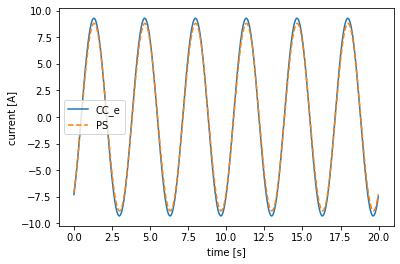

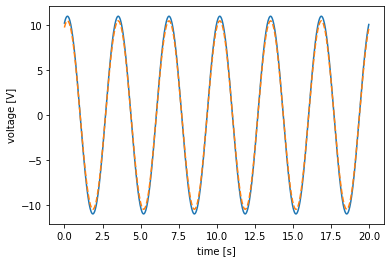

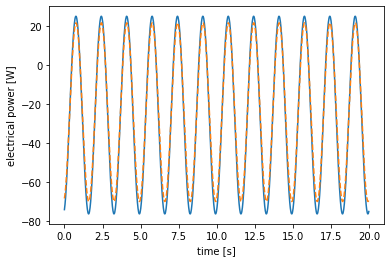

In [8]:
nsubsteps = 10
t = wec.make_time_vec(nsubsteps)

# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')